# Sampling on binarized MNIST

**Note:**

sklearn == 0.21.3 required for imblearn 0.5.0 to work. It's easiest to create a new conda env from scratch with sklearn and imblearn.

**Method**

1. group some of the MNIST classes into two groups (binarizing)
2. split the selected samples into train / test (`train_frac`) → the larger `train_frac` the better the coverage of the feature space
3. skew one of the two created classes (`skew_frac`)
4. apply oversampling & train

**Objective**

Test the benefit of using an oversampler vs not using one and the effect of `train_frac` (`skew_frac` was set to 2% as in the ROSE paper and not further explored). 

In [4]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
from sklearn import ensemble, metrics, base, linear_model
import pandas as pd
import seaborn as sns
import tqdm
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

In [5]:
plt.style.use('bmh')

In [6]:
%%time
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

CPU times: user 11 s, sys: 1.03 s, total: 12.1 s
Wall time: 12.1 s


In [7]:
X.shape, X[:5,:5], y[:5]

((70000, 784),
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array(['5', '0', '4', '1', '9'], dtype=object))

In [8]:
X = pd.DataFrame(X).add_prefix('pixel')
y = pd.DataFrame({'class':y})
y = y['class'].astype('category')

In [9]:
display(X.head(), y.head())

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): [0, 1, 2, 3, ..., 6, 7, 8, 9]

In [10]:
df = X.join(y)
len(df), display(df.head())

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


(70000, None)

## Pre-processing

### Binarizing

Reducing to 0 and 1

In [11]:
def get_share_and_count(df:pd.DataFrame, col:str='class'):
    share = df[col].value_counts(normalize=True).rename('share')
    count = df[col].value_counts(normalize=False).rename('count')
    return share.to_frame().join(count)

def make_binary(df:pd.DataFrame, set0:set, set1:set):
    'Binarize any two sets of classes and return a DataFrame for only those classes labeled as False or True'
    assert len(set0) > 0 and len(set1) > 0
    assert set0 != set1
    
    df_b0 = df.loc[df['class'].isin(set0)].copy()
    df_b1 = df.loc[df['class'].isin(set1)].copy()
    df_b0['class'] = False
    df_b1['class'] = True
    
    df_b = pd.concat((df_b0, df_b1))
    df_b['class'] = df_b['class'].astype('category')
    return df_b

In [12]:
%%time
df_b = make_binary(df, {'0', '1'}, {'4'})
print(f'df: {len(df)}, df_b: {len(df_b)}')
display(get_share_and_count(df_b))

df: 70000, df_b: 21604


,share,count
False,0.684133,14780
True,0.315867,6824


CPU times: user 93.8 ms, sys: 219 ms, total: 312 ms
Wall time: 365 ms


In [13]:
%%time
df_b = make_binary(df, {'0'}, {'8'})
print(f'df: {len(df)}, df_b: {len(df_b)}')

df: 70000, df_b: 13728
CPU times: user 78.1 ms, sys: 78.1 ms, total: 156 ms
Wall time: 173 ms


### Get skewed training set & balanced test set

In [14]:
def get_skewed_train_and_balanced_test_set(df_b:pd.DataFrame, train_frac:float=.8, skew_frac:float=.02,
                                           class_to_skew:bool=True, verbose:bool=False):
    '''Generates a balanced test set and a skewed training set with `class_to_skew` 
    making up the fraction `skew_frac` of the total.
    
    Works with the `df_b` produced by `make_binary`.
    '''
    df_test = df_b.sample(frac=1-train_frac)
    df_train = df_b.loc[~df_b['class'].index.isin(df_test.index)]
    
    n = min(df_train['class'].value_counts().values)
    n_skew = int(n * skew_frac / (1 - skew_frac))
    
    df_train = pd.concat((
        df_train.loc[df_train['class']==class_to_skew].iloc[:n].sample(n=n_skew),
        df_train.loc[df_train['class']!=class_to_skew].iloc[:n]
    ))
    
    if verbose:
        print(f'train set: {len(df_train)}')
        display(get_share_and_count(df_train))
        print(f'test set: {len(df_test)}')
        display(get_share_and_count(df_test))
    return df_train, df_test

In [15]:
%%time
df_train, df_test = get_skewed_train_and_balanced_test_set(df_b, train_frac=.8, skew_frac=.02, class_to_skew=True,
                                                           verbose=True)

train set: 5587


,share,count
False,0.980132,5476
True,0.019868,111


test set: 2746


,share,count
False,0.50874,1397
True,0.49126,1349


CPU times: user 93.8 ms, sys: 78.1 ms, total: 172 ms
Wall time: 147 ms


In [16]:
def get_Xy(df:pd.DataFrame, x_col_pattern:str='pixel', y_col:str='class'):
    x_cols = [c for c in df.columns if c.startswith(x_col_pattern)]
    X = df.loc[:,].values.astype(float)
    y = df.loc[:, y_col].values.astype(int)
    return X, y

In [17]:
X_train, y_train = get_Xy(df_train)
X_train[:5,:5], y_train[:5], X_train.shape, y_train.shape

(array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([1, 1, 1, 1, 1]),
 (5587, 785),
 (5587,))

In [18]:
X_test, y_test = get_Xy(df_test)
X_test[:5,:5], y_test[:5], X_test.shape, y_test.shape

(array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([1, 1, 1, 0, 0]),
 (2746, 785),
 (2746,))

### Impact of sampler on the cardinality of `X`

In [19]:
def get_X_cardinality(X:np.ndarray):
    return len(set([tuple(x) for x in X]))

Unsampled

In [20]:
print(f'train - samples: {len(X_train)}, cardinality: {get_X_cardinality(X_train)}')

train - samples: 5587, cardinality: 5587


`RandomOverSampler`

In [21]:
_X, _y = RandomOverSampler().fit_resample(X_train, y_train)
print(f'train - samples: {len(_X)}, cardinality: {get_X_cardinality(_X)}')

train - samples: 10952, cardinality: 5587


`SMOTE`

In [22]:
_X, _y = SMOTE().fit_resample(X_train, y_train)
print(f'train - samples: {len(_X)}, cardinality: {get_X_cardinality(_X)}')

train - samples: 10952, cardinality: 10952


## Going nuts

In [23]:
def ELWMS(df:pd.DataFrame, set0:set={'0'}, set1:set={'1'}, n_rep:int=10, 
          train_frac:float=.8, skew_frac:float=.02, class_to_skew:bool=True,
          model_specs:dict=None, model_class:base.ClassifierMixin=linear_model.LogisticRegression,
          samplers:dict={'ROS':RandomOverSampler, 'SMOTE': SMOTE, 'nothing': None}, verbose:bool=False):
    '''Eierlegendewollmilchsau (performs all the steps above repeatedly)
    
    set0: defines which MNIST classes are mapped to False/0
    set1: defines which MNIST classes are mapped to True/1
    train_frac: defines how large the training set is
    skew_frac: defines how large the class True in the training set is
    
    Tip: If you want a tiny training set which is heavily skewed towards the class False
    set `train_frac` = .1, `skew_frac` = .02 and `class_to_skew` = False. This yields
    a training set with 2% True, 98% False, based on 10% of the complete data.
    '''
    
    results = []
    
    if model_specs is None:
        model_specs = dict()
    elif isinstance(model_class, ensemble.RandomForestClassifier) and model_specs is None:
        model_specs = dict(n_estimators=100, max_features='sqrt')
    
    
    for rep in range(n_rep):
        
        # binarizing sets of MNIST classes
        df_b = make_binary(df, set0, set1)
        
        # splitting and skewing
        df_train, df_test = get_skewed_train_and_balanced_test_set(df_b, train_frac=train_frac, 
                                                                   skew_frac=skew_frac, 
                                                                   class_to_skew=class_to_skew)
        if verbose:
            print(f'\nrep {rep+1}/{n_rep}\n\ttraining set: {len(df_train)}, test set: {len(df_test)}')
            print('class share in training set')
            display(get_share_and_count(df_train))
            print('class share in test set')
            display(get_share_and_count(df_test))
        
        # collecting X and y
        X_train, y_train = get_Xy(df_train)
        X_test, y_test = get_Xy(df_test)
        
        # going through the different samplers
        for name, sampler in samplers.items():
            if sampler is None:
                _X_train, _y_train = X_train.copy(), y_train.copy()
            else:
                sam = sampler()
                _X_train, _y_train = sam.fit_resample(X_train, y_train)

            model = model_class(**model_specs)
            model.fit(_X_train, _y_train)

            y_pred = model.predict(X_test)
            y_score = model.predict_proba(X_test)
            roc_auc_True = metrics.roc_auc_score(y_test == True, y_score[:,1])
            roc_auc_False = metrics.roc_auc_score(y_test == False, y_score[:,0])
            
            res = metrics.classification_report(y_test, y_pred, output_dict=True)
            d = {k:v for k,v in res.items() if not isinstance(v,dict)}
            d['sampler'] = name
            d['1->roc auc'] = roc_auc_True
            d['0->roc auc'] = roc_auc_False
            for k,v in res.items():
                if isinstance(v,dict):
                    d.update({f'{k}->{_k}': _v for _k,_v in v.items()})
            results.append(d)
            
    results = pd.DataFrame(results)
    results['train_frac'] = train_frac
    return results

### Testing a single parameter combination

In [68]:
%%time
samplers = {'ROS':RandomOverSampler, 'SMOTE': SMOTE, 'nothing': None}
model_class = linear_model.LogisticRegression
model_specs = {'solver':'lbfgs'}

# assigning classes into groups for binarization (can use multiple classes per group)
set0 = {'0'}  # all 0s belong to set 0
set1 = {'2'}  # all 2s belong to set 1

results = ELWMS(df, 
                set0=set0, set1=set1, 
                n_rep=10, 
                train_frac=.8, skew_frac=.02, class_to_skew=True,
                model_class=model_class, model_specs=model_specs, samplers=samplers,
                verbose=True)


rep 1/10
	training set: 5645, test set: 2779
class share in training set


,share,count
False,0.980159,5533
True,0.019841,112


class share in test set


,share,count
True,0.507017,1409
False,0.492983,1370


/mnt/c/Programs_wsl/anaconda3/envs/py37_imbalanced/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



rep 2/10
	training set: 5600, test set: 2779
class share in training set


,share,count
False,0.98,5488
True,0.02,112


class share in test set


,share,count
False,0.509176,1415
True,0.490824,1364


/mnt/c/Programs_wsl/anaconda3/envs/py37_imbalanced/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_imbalanced/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_imbalanced/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



rep 3/10
	training set: 5640, test set: 2779
class share in training set


,share,count
False,0.980142,5528
True,0.019858,112


class share in test set


,share,count
True,0.505218,1404
False,0.494782,1375



rep 4/10
	training set: 5642, test set: 2779
class share in training set


,share,count
False,0.980149,5530
True,0.019851,112


class share in test set


,share,count
True,0.505937,1406
False,0.494063,1373



rep 5/10
	training set: 5613, test set: 2779
class share in training set


,share,count
False,0.980046,5501
True,0.019954,112


class share in test set


,share,count
False,0.504498,1402
True,0.495502,1377


/mnt/c/Programs_wsl/anaconda3/envs/py37_imbalanced/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_imbalanced/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



rep 6/10
	training set: 5628, test set: 2779
class share in training set


,share,count
False,0.9801,5516
True,0.0199,112


class share in test set


,share,count
True,0.5009,1392
False,0.4991,1387


/mnt/c/Programs_wsl/anaconda3/envs/py37_imbalanced/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_imbalanced/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_imbalanced/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



rep 7/10
	training set: 5650, test set: 2779
class share in training set


,share,count
False,0.98,5537
True,0.02,113


class share in test set


,share,count
True,0.508456,1413
False,0.491544,1366



rep 8/10
	training set: 5635, test set: 2779
class share in training set


,share,count
False,0.980124,5523
True,0.019876,112


class share in test set


,share,count
True,0.503418,1399
False,0.496582,1380


/mnt/c/Programs_wsl/anaconda3/envs/py37_imbalanced/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



rep 9/10
	training set: 5622, test set: 2779
class share in training set


,share,count
False,0.980078,5510
True,0.019922,112


class share in test set


,share,count
False,0.501259,1393
True,0.498741,1386



rep 10/10
	training set: 5592, test set: 2779
class share in training set


,share,count
False,0.98015,5481
True,0.01985,111


class share in test set


,share,count
False,0.511695,1422
True,0.488305,1357


CPU times: user 51.9 s, sys: 7.73 s, total: 59.6 s
Wall time: 23.6 s


In [69]:
results.head()

,accuracy,sampler,1->roc auc,0->roc auc,0->precision,0->recall,0->f1-score,0->support,1->precision,1->recall,...,1->support,macro avg->precision,macro avg->recall,macro avg->f1-score,macro avg->support,weighted avg->precision,weighted avg->recall,weighted avg->f1-score,weighted avg->support,train_frac
0,0.957899,ROS,0.996692,0.996333,0.921886,0.999270,0.959019,1370,0.999227,0.917672,...,1409,0.960556,0.958471,0.957867,2779,0.961099,0.957899,0.957851,2779,0.8
1,0.957179,SMOTE,0.996679,0.996307,0.920646,0.999270,0.958348,1370,0.999226,0.916253,...,1409,0.959936,0.957761,0.957145,2779,0.960487,0.957179,0.957128,2779,0.8
2,0.950702,nothing,0.996749,0.996231,0.909635,0.999270,0.952348,1370,0.999215,0.903478,...,1409,0.954425,0.951374,0.950643,2779,0.955053,0.950702,0.950619,2779,0.8
3,0.963656,ROS,0.998105,0.997996,0.933950,0.999293,0.965517,1415,0.999209,0.926686,...,1364,0.966580,0.962990,0.963550,2779,0.965981,0.963656,0.963586,2779,0.8
4,0.964736,SMOTE,0.998105,0.998007,0.935804,0.999293,0.966507,1415,0.999211,0.928886,...,1364,0.967508,0.964089,0.964637,2779,0.966926,0.964736,0.964671,2779,0.8


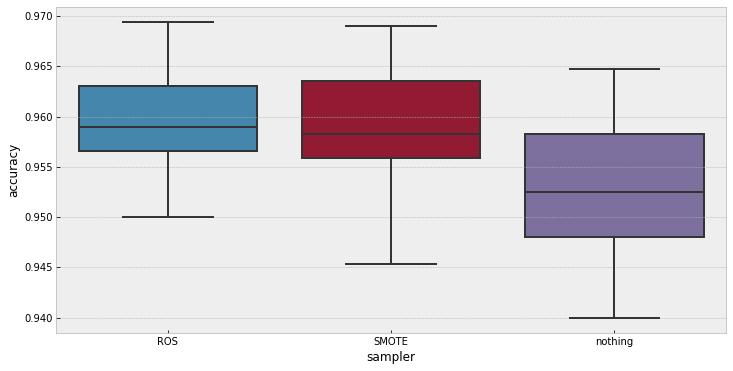

In [70]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=results, x='sampler', y='accuracy', ax=ax)
plt.show()

To more clearly see the difference of using samplers, the scores are subtracted by the median of the values obtained for the case without a sampler, labelled 'nothing'.

In [71]:
def get_score_difference_to_reference_sampler(df:pd.DataFrame, agg_func_for_reference:Callable=np.median,
                                      reference_sampler:str='nothing'):
    'Expects the output of `ELWMS` as input'
    delta = df.copy()
    cols = [c for c in delta.columns if c != 'sampler' and c!= 'train_frac']
    ref = delta.loc[delta['sampler']=='nothing', cols].agg(agg_func_for_reference, axis=0)
    delta.loc[:, cols] = delta.loc[:, cols] - ref
    return delta

In [72]:
results_delta = get_score_difference_to_reference_sampler(results,
                                                          agg_func_for_reference=np.median)
results_delta.head()

,accuracy,sampler,1->roc auc,0->roc auc,0->precision,0->recall,0->f1-score,0->support,1->precision,1->recall,...,1->support,macro avg->precision,macro avg->recall,macro avg->f1-score,macro avg->support,weighted avg->precision,weighted avg->recall,weighted avg->f1-score,weighted avg->support,train_frac
0,0.005398,ROS,-0.000593,-0.000659,0.009532,-0.000378,0.004852,-13.5,-0.000382,0.011621,...,13.5,0.004380,0.005445,0.005429,0.0,0.004433,0.005398,0.005432,0.0,0.8
1,0.004678,SMOTE,-0.000606,-0.000685,0.008293,-0.000378,0.004181,-13.5,-0.000384,0.010201,...,13.5,0.003759,0.004736,0.004707,0.0,0.003821,0.004678,0.004709,0.0,0.8
2,-0.001799,nothing,-0.000536,-0.000761,-0.002719,-0.000378,-0.001819,-13.5,-0.000395,-0.002574,...,13.5,-0.001752,-0.001652,-0.001795,0.0,-0.001613,-0.001799,-0.001800,0.0,0.8
3,0.011155,ROS,0.000820,0.001005,0.021597,-0.000355,0.011350,31.5,-0.000400,0.020635,...,-31.5,0.010403,0.009964,0.011112,0.0,0.009315,0.011155,0.011167,0.0,0.8
4,0.012235,SMOTE,0.000820,0.001015,0.023451,-0.000355,0.012340,31.5,-0.000398,0.022834,...,-31.5,0.011331,0.011064,0.012199,0.0,0.010260,0.012235,0.012252,0.0,0.8


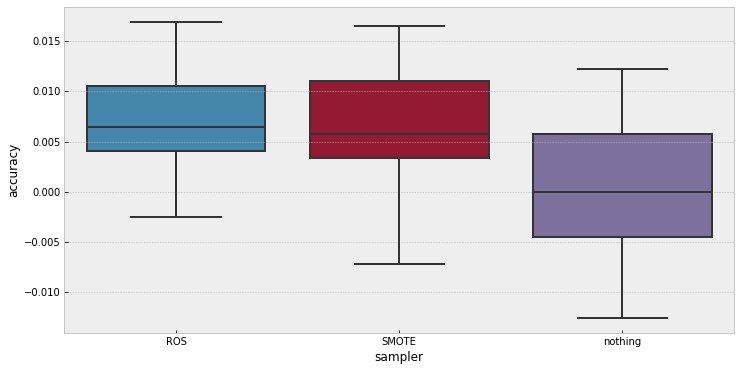

In [73]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=results_delta, x='sampler', y='accuracy', ax=ax)
plt.show()

### Scanning a range of `train_frac` values

In [87]:
samplers = {'ROS':RandomOverSampler, 'SMOTE': SMOTE, 'nothing': None}
# model_class = linear_model.LogisticRegression
# model_specs = {'solver':'lbfgs'}
model_class = ensemble.RandomForestClassifier
model_specs = dict(n_estimators=100, max_features='sqrt')

set0 = {'3'}
set1 = {'5'}

n_rep = 20

# The label True will make up about 2% of the training set's labels
skew_frac = .02
class_to_skew = True

settings = dict(samplers=samplers, model_class=model_class, model_specs=model_specs, set0=set0, set1=set1,
                n_rep=n_rep, skew_frac=skew_frac, class_to_skew=class_to_skew)

train_frac_range = [.8, .6, .4, .2, .1]

In [88]:
%%time
scan_results = []
scan_results_delta = []

for train_frac in tqdm.tqdm(train_frac_range, total=len(train_frac_range)):
    _results = ELWMS(df, train_frac=train_frac,
                     **settings)
    scan_results.append(_results)
    
    # for clearer visualisation of the effect of samplers vs no sampling
    _results_delta = get_score_difference_to_reference_sampler(_results,
                                                               agg_func_for_reference=np.median)
    
    scan_results_delta.append(_results_delta)
        
scan_results = pd.concat(scan_results, ignore_index=True)
scan_results_delta = pd.concat(scan_results_delta, ignore_index=True)

100%|██████████| 5/5 [09:08<00:00, 109.66s/it]

CPU times: user 7min 58s, sys: 1min 7s, total: 9min 5s
Wall time: 9min 8s


#### Plotting score vs sampler and training / test set size

Grouping by sampler

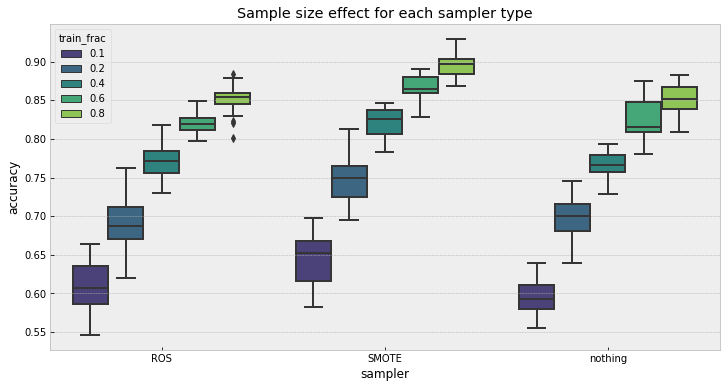

In [89]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='sampler', y='accuracy', hue='train_frac', data=scan_results,
                 ax=ax, palette='viridis')
ax.set(title='Sample size effect for each sampler type')
plt.show()

Grouping by `train_frac`

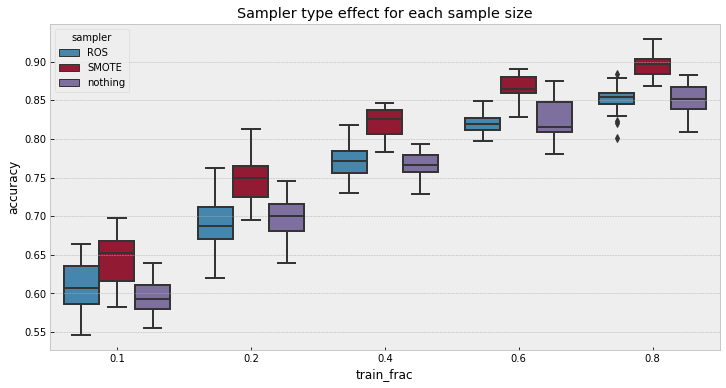

In [90]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='train_frac', y='accuracy', hue='sampler', data=scan_results,
                 ax=ax)
ax.set(title='Sampler type effect for each sample size')
plt.show()

#### Plotting score DIFFERENCE vs sampler and training / test set size

To more clearly see the difference of using samplers, the scores are subtracted by the median of the values obtained for the case without a sampler, labelled 'nothing'.

In [91]:
plot_mask = scan_results_delta['sampler']!='nothing'

**Accuracy** - Grouping by sampler

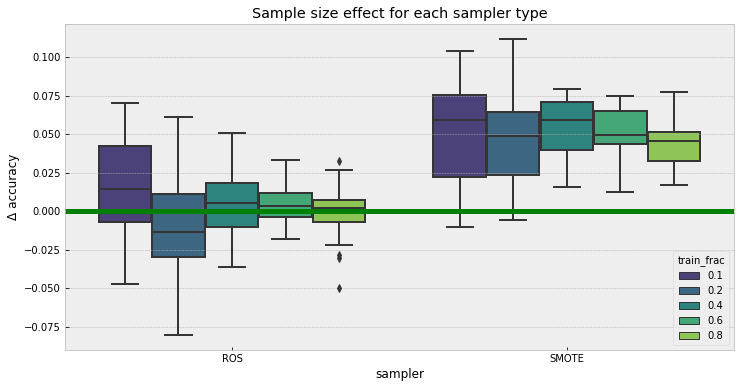

In [92]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='sampler', y='accuracy', hue='train_frac', 
                 data=scan_results_delta.loc[plot_mask,:],
                 ax=ax, palette='viridis')
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '-g', lw=5)
ax.set(title='Sample size effect for each sampler type', xlim=xlim,
       ylabel='Δ accuracy')
plt.show()

**Accuracy** - Grouping by `train_frac`

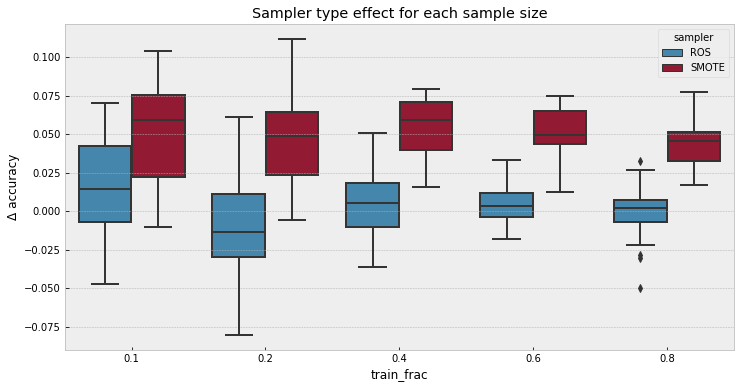

In [93]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='train_frac', y='accuracy', hue='sampler', 
                 data=scan_results_delta.loc[plot_mask,:],
                 ax=ax)
ax.set(title='Sampler type effect for each sample size',
       ylabel='Δ accuracy')
plt.show()

**F1-score (for 1)** Grouping by sampler

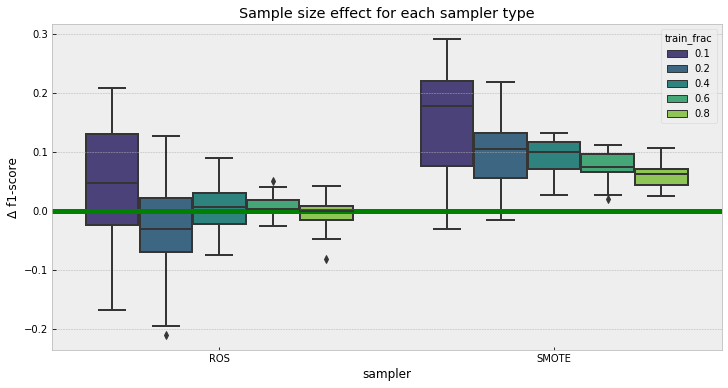

In [94]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='sampler', y='1->f1-score', hue='train_frac', 
                 data=scan_results_delta.loc[plot_mask],
                 ax=ax, palette='viridis')
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '-g', lw=5)
ax.set(title='Sample size effect for each sampler type', xlim=xlim,
       ylabel='Δ f1-score')
plt.show()

**F1-score (for 1)** Grouping by `train_frac`

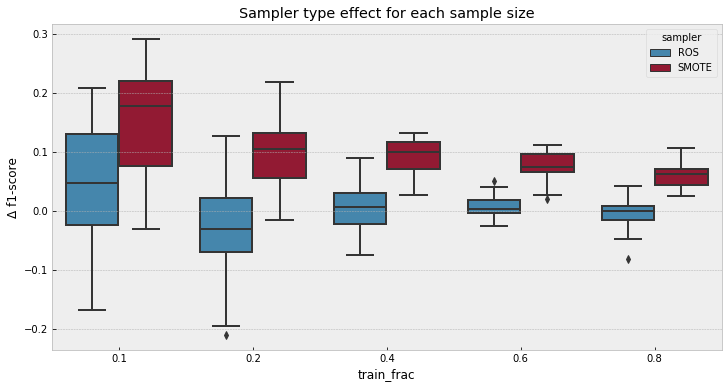

In [95]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='train_frac', y='1->f1-score', hue='sampler', 
                 data=scan_results_delta.loc[plot_mask],
                 ax=ax)
ax.set(title='Sampler type effect for each sample size',
       ylabel='Δ f1-score')
plt.show()

**ROC AUC-score (for 1)** Grouping by sampler

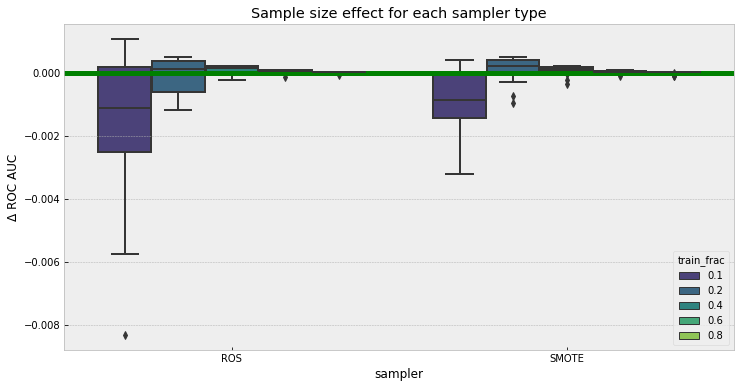

In [96]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='sampler', y='1->roc auc', hue='train_frac', 
                 data=scan_results_delta.loc[plot_mask,:],
                 ax=ax, palette='viridis')
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '-g', lw=5)
ax.set(title='Sample size effect for each sampler type', xlim=xlim,
       ylabel='Δ ROC AUC')
plt.show()

## Summary

It seems the samplers `RandomOverSampler` and `SMOTE` behave similar, using their default settings, in showing increasingly larger gains over no sampler ('nothing') the smaller the training data set is.